<a href="https://colab.research.google.com/github/alunfes/1m-btc-data/blob/master/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Tue Dec 27 00:23:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#%cp -rp '/content/drive/My Drive/ta-lib/' ~/
%cd ~
!rm -rf ta-lib*
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd '/content/drive/My Drive/ta-lib'
#%cd ta-lib
import os
#os.chdir('/content/drive/My Drive/ta-lib') # Can't use !cd in co-lab
os.chdir('ta-lib') # Can't use !cd in co-lab
#%cd ~/ta-lib
!./configure --prefix=/usr
#! '/content/drive/My Drive/ta-lib/configure' --prefix=/usr
!make
!make install
!pip install Ta-Lib
%cd /content

/root
--2022-12-27 00:23:52--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving sourceforge.net (sourceforge.net)... 104.18.10.128, 104.18.11.128, 2606:4700::6812:b80, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.10.128|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/ [following]
--2022-12-27 00:23:52--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download [following]
--2022-12-27 00:23:52--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting r

In [4]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torch.optim import Adam
import numpy as np
import pandas as pd
import talib as ta
import math
import scipy
from scipy import fftpack, signal
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline
print(torch.__version__)

1.13.0+cu116


In [6]:
class MarketData:
    @classmethod
    def initialize(cls, terms):
        cls.terms = terms
        cls.df = pd.DataFrame()
        cls.ts = []
        cls.open = []
        cls.high = []
        cls.low = []
        cls.close = []
        cls.vol = []
        cls.__read_data()
        cls.logopen = list(np.log(cls.open))
        cls.loghigh = list(np.log(cls.high))
        cls.loglow = list(np.log(cls.low))
        cls.logclose = list(np.log(cls.close))
        cls.close_change_ratio = list(np.array(pd.DataFrame(cls.close).pct_change().values.tolist()).reshape(len(cls.close)))
        cls.logclose_change_ratio = list(np.array(pd.DataFrame(cls.logclose).pct_change().values.tolist()).reshape(len(cls.logclose)))
        cls.ma_kairi = {}
        cls.__calc_index()
    
    @classmethod
    def __read_data(cls):
        cls.df = pd.read_csv('/content/drive/My Drive/BTC-PERP-1mcp.csv')
        cls.ts = list(cls.df['ts'])
        cls.open = list(cls.df['open'])
        cls.high = list(cls.df['high'])
        cls.low = list(cls.df['low'])
        cls.close = list(cls.df['close'])
        cls.vol = list(cls.df['volume'])

    @classmethod
    def __calc_index(cls):
        for term in cls.terms:
            cls.ma_kairi[term] = cls.__calc_ma_kairi(term)

    @classmethod
    def __calc_ma_kairi(cls, term):
        ma = list(ta.MA(np.array(cls.close, dtype='f8'), timeperiod=term))
        return list(map(lambda c, e: (c - e) / e, np.array(cls.close, dtype='f8'), np.array(ma, dtype='f8')))
    
    @classmethod
    def __calc_rsi(cls, term):
        return ta.RSI(np.array(cls.logclose, dtype='f8'), timeperiod=term)
    
    @classmethod
    def __calc_williams_R(cls, term):
        return list(ta.WILLR(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'),timeperiod=term))
        
    @classmethod
    def __calc_macdfix(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist =  ta.MACD(np.array(cls.logclose, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'), np.array(signalperiod, dtype='i8'))
        return macd

    @classmethod
    def __calc_aroon_os(cls, term):
        return list(ta.AROONOSC(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_cci(cls, term):
        return list(ta.CCI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_dx(cls, term):
        return list(ta.DX(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_stochastic(cls, term):
        k_term = term
        d_term = int(term / 2.0)
        fastk, fastd = ta.STOCHF(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), fastk_period=k_term, fastd_period=d_term, fastd_matype=0)
        return list(np.array(fastk) / np.array(fastd))


    @classmethod
    def __calc_cmo(cls, term):
        return list(ta.CMO(np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_adxr(cls, term):
        return ta.ADXR(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)

    @classmethod
    def __calc_apo(cls, term):
        fperiod=term
        speriod=term * 2
        return ta.APO(np.array(cls.logclose, dtype='f8'), fastperiod=fperiod, slowperiod=speriod, matype=0)

    @classmethod
    def __calc_plus_minus_di(cls, term):
        mdi = ta.MINUS_DI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)
        pdi = ta.PLUS_DI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)
        return list(np.array(mdi) / np.array(pdi))

    @classmethod
    def __calc_ppo(cls, term):
        fperiod = term
        speriod = term * 2
        return ta.PPO(np.array(cls.logclose, dtype='f8'), fastperiod=fperiod, slowperiod=speriod, matype=0)

    @classmethod
    def __calc_ultosc(cls, term):
        p2 = int(term / 2.0)
        p1 = int(term / 3.0)
        return ta.ULTOSC(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod1=p1, timeperiod2=p2, timeperiod3=term)

MarketData.initialize([30, 60])

In [7]:
###########################################################
#####################Positonal Encoder#########################
###########################################################
'close, MA kairiは毎回同じ長さの入力なので単調なpositional encodingでOK'
class PositionalEncoder:
    def getMonotoneSeqPositionalEncoding(self, seq_len, num_dim):
        pm = [np.linspace(0.0, 1.0, seq_len), np.linspace(0.0, 1.0, seq_len)]
        return np.array(pm)

In [8]:
###########################################################
#########################Dataset############################
###########################################################
class CustomDataset(Dataset):
    def __init__(self, from_ind, to_ind, input_length, output_length, sampling_window, term):
        self.input, self.output = self.__generate_data(from_ind, to_ind, input_length, input_length, sampling_window, term)

    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        return torch.tensor(self.input[index], dtype = torch.float32), torch.tensor(self.output[index], dtype=torch.float32)

    def __generate_data(self, from_ind, to_ind, input_length, output_length, sampling_window, term):
        logclose = []
        ma_kairi = []
        x = []
        y = []
        current_start = from_ind
        mmsc = MinMaxScaler(feature_range=(0,1), copy=True)
        while True:
            logclose.append(mmsc.fit_transform(np.array(MarketData.logclose[current_start : current_start + input_length]).reshape(-1,1)))
            ma_kairi.append(np.array(MarketData.ma_kairi[term][current_start : current_start + input_length]).reshape(-1,1))
            '''
            data = MarketData.close_change_ratio[current_start + input_length : current_start + input_length + output_length]
            #mean, std, skew, kurtosis, period, price, change ratio, period price max-min change ratio
            y.append(np.array(
                [np.mean(data), np.std(data), scipy.stats.skew(data), scipy.stats.kurtosis(data),
                 100 * (MarketData.close[current_start + input_length + output_length - 1] - MarketData.close[current_start + input_length]) / MarketData.close[current_start + input_length],
                 100 * (max(MarketData.close[current_start + input_length : current_start + input_length + output_length]) - min(MarketData.close[current_start + input_length : current_start + input_length + output_length])) / min(MarketData.close[current_start + input_length : current_start + input_length + output_length])
                 ]
            ).reshape(-1,1))
            '''
            y.append(mmsc.fit_transform(np.array(MarketData.logclose[current_start + input_length : current_start + input_length + output_length]).reshape(-1,1)))
            current_start += sampling_window
            if current_start >= to_ind:
                break
        x = np.array([logclose, ma_kairi])
        x = x.reshape(x.shape[1], x.shape[0], x.shape[2])
        y = np.array(y)
        #positional encoding
        pe = PositionalEncoder()
        pe_array = pe.getMonotoneSeqPositionalEncoding(input_length, 2)
        encoded_input = []
        for input_data in x:
            close = input_data[0] + pe_array[0]
            kairi = input_data[1] + pe_array[1]
            encoded_input.append([close, kairi])
        encoded_input = np.array(encoded_input)
        
        print(np.where(np.isnan(encoded_input)))
        print(np.where(np.isnan(y)))
        return np.squeeze(encoded_input), np.squeeze(y)


train_batch_size = 3000
input_length = 1800
output_length = 60
sampling_window = 100
dataset = CustomDataset(800000, 1300000, input_length, output_length, sampling_window, 60)
train_size = int(0.7 * len(dataset))
valid_size = int(0.1 * len(dataset))
train_set = torch.utils.data.Subset(dataset, range(train_size))
valid_set = torch.utils.data.Subset(dataset, range(train_size, train_size + valid_size))
test_set = torch.utils.data.Subset(dataset, range(train_size + valid_size, len(dataset)))
train_dataloader = DataLoader(train_set, batch_size = train_batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_set)
test_dataloader = DataLoader(test_set)
for x, y in train_dataloader:
    print(x.shape, y.shape)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
torch.Size([3000, 2, 1800]) torch.Size([3000, 1800])
torch.Size([500, 2, 1800]) torch.Size([500, 1800])


In [10]:
###########################################################
###################Multi Head Attention########################
###########################################################
'''
class ScaledDotProductAttention(nn.Module):
    def __init__(self, q, k, v):
        super(ScaledDotProductAttention, self).__init__()
        #matnul for q & k
        matmul_qk = torch.matmul(q, torch.t(k))
        #scale
        matmul_qk = matmul_qk / np.sqrt(q.shape[-1])
        #softmax
        matmul_qk = F.softmax(matmul_qk)
        #matmul for qk & v
        matmul_qkv = torch.matmul(matmul_qk, v)
        self.scale = torch.matmul(q, torch.t(k)) / np.sqrt(q.shape[-1])
    
    def forward(self, q, k, v):
        q = q.unsqueeze(1) # [B,Q] -> [B,1,Q]
        k = k.permute(1,2,0) # [T,B,K] -> [B,K,T]
        energy = torch.bmm(q, k) # [B,1,Q]*[B,K,T] = [B,1,T]
        energy = self.softmax(energy.mul_(self.scale))


class MutliHeadAttention(nn.Module):
    def __init__(self, q, k, v):
        super(MutliHeadAttention, self).__init__()

        ScaledDotProductAttention()
'''

'\nclass ScaledDotProductAttention(nn.Module):\n    def __init__(self, q, k, v):\n        super(ScaledDotProductAttention, self).__init__()\n        #matnul for q & k\n        matmul_qk = torch.matmul(q, torch.t(k))\n        #scale\n        matmul_qk = matmul_qk / np.sqrt(q.shape[-1])\n        #softmax\n        matmul_qk = F.softmax(matmul_qk)\n        #matmul for qk & v\n        matmul_qkv = torch.matmul(matmul_qk, v)\n        self.scale = torch.matmul(q, torch.t(k)) / np.sqrt(q.shape[-1])\n    \n    def forward(self, q, k, v):\n        q = q.unsqueeze(1) # [B,Q] -> [B,1,Q]\n        k = k.permute(1,2,0) # [T,B,K] -> [B,K,T]\n        energy = torch.bmm(q, k) # [B,1,Q]*[B,K,T] = [B,1,T]\n        energy = self.softmax(energy.mul_(self.scale))\n\n\nclass MutliHeadAttention(nn.Module):\n    def __init__(self, q, k, v):\n        super(MutliHeadAttention, self).__init__()\n\n        ScaledDotProductAttention()\n'

In [9]:
###########################################################
######################### BERT Model ########################
###########################################################
class Transformer(nn.Module):
    def __init__(self, inputs_shape, num_heads, dropout_ratio, device, dtype):
        #super(Transformer, self).__init__()
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=inputs_shape[-1], num_heads=num_heads, dropout=dropout_ratio, device = device, dtype = dtype)
        self.norm1 = nn.LayerNorm(inputs_shape[-1], inputs_shape[-1], device = device, dtype = dtype)
        self.linear1 = nn.Linear(inputs_shape[-1], inputs_shape[-1], device = device, dtype = dtype)
        self.softplus1 = nn.Softplus()
        self.linear2 = nn.Linear(inputs_shape[-1], inputs_shape[-1], device = device, dtype = dtype)
        self.softplus2 = nn.Softplus()
        self.do1 = nn.Dropout(p=dropout_ratio)
        self.norm2 = nn.LayerNorm(inputs_shape[-1], device = device, dtype = dtype)

    def forward(self, inputs):
        output = self.mha(inputs, inputs, inputs)
        output_norm = self.norm1(output[0] + inputs)
        output = self.linear1(output_norm)
        output = self.softplus1(output[0])
        output = self.linear2(output)
        output = self.do1(output)
        output = self.norm2(output + output_norm)
        return output


class Bert(nn.Module):
    def __init__(self, inputs_shape, outputs_shape, num_heads, dropout_ratio, device, dtype):
        #super(Bert, self).__init__()
        super().__init__()
        self.transformer1 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer2 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer3 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer4 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer5 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.transformer6 = Transformer(inputs_shape, num_heads, dropout_ratio, device, dtype)
        self.flatten1 = nn.Flatten()
        self.linear1 = nn.Linear(inputs_shape[-1] * inputs_shape[-2], outputs_shape[-1], device = device, dtype = dtype)

    def forward(self, inputs):
        output = self.transformer1(inputs)
        output = self.transformer2(output)
        output = self.transformer3(output)
        output = self.transformer4(output)
        output = self.transformer5(output)
        output = self.transformer6(output)
        output = self.flatten1(output)
        output = self.linear1(output)
        return output





device= cuda
Epoch: 1/50, Loss: 0.524541512131691
Epoch: 2/50, Loss: 0.22246049344539642
Epoch: 3/50, Loss: 0.18679845333099365
Epoch: 4/50, Loss: 0.18974297493696213
Epoch: 5/50, Loss: 0.18779627978801727
Epoch: 6/50, Loss: 0.1797102764248848
Epoch: 7/50, Loss: 0.1692967191338539
Epoch: 8/50, Loss: 0.16018006950616837
Epoch: 9/50, Loss: 0.1573042869567871
Epoch: 10/50, Loss: 0.1534203663468361
Epoch: 11/50, Loss: 0.15724046528339386
Epoch: 12/50, Loss: 0.1548793613910675
Epoch: 13/50, Loss: 0.149666465818882
Epoch: 14/50, Loss: 0.14851201325654984
Epoch: 15/50, Loss: 0.146368145942688
Epoch: 16/50, Loss: 0.14459456503391266
Epoch: 17/50, Loss: 0.14850760996341705
Epoch: 18/50, Loss: 0.1518983244895935
Epoch: 19/50, Loss: 0.13969191163778305
Epoch: 20/50, Loss: 0.13953609019517899
Epoch: 21/50, Loss: 0.13608773797750473
Epoch: 22/50, Loss: 0.1355959251523018
Epoch: 23/50, Loss: 0.1469331979751587
Epoch: 24/50, Loss: 0.13470105081796646
Epoch: 25/50, Loss: 0.1485234722495079
Epoch: 26/5

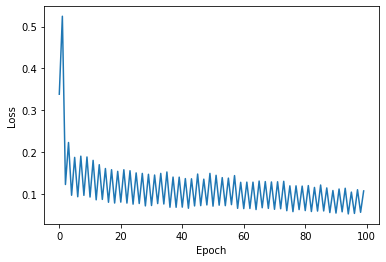

In [10]:
###########################################################
######################### Train Model ########################
###########################################################
class ModelTrain:
    def train(self, num_epochs, train_dataloader):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print('device=', device)

        model = Bert(train_dataloader.dataset[0][0].shape, train_dataloader.dataset[0][1].shape, 1, 0.2, device, torch.float32)
        model.to(device)
        model.train()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        loss_fn = nn.MSELoss()
        loss_history = []
        
        for epoch in range(num_epochs):
            avg_loss = 0
            count = 0
            loss_sum = 0
            for inputs, labels in train_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                loss_sum += loss.item()
                optimizer.step()
                count+=1
                loss_history.append(loss_sum / len(train_dataloader))
            print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss_sum / len(train_dataloader)}")
        return model, loss_history

train = ModelTrain()
model, loss_history = train.train(50, train_dataloader)
torch.save(model.state_dict(), './pytorch_model') 

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

device= cuda
# 0 , loss= 0.11581174284219742 ave_loss= 0.1158


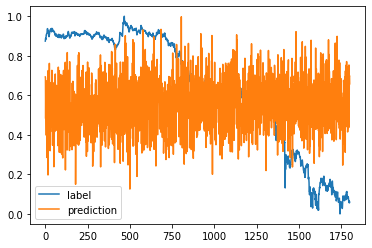

# 1 , loss= 0.12287014722824097 ave_loss= 0.1193


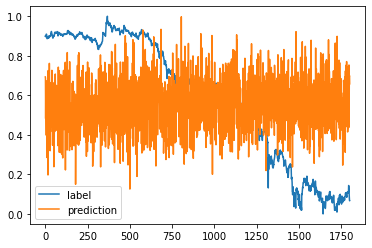

# 2 , loss= 0.09873050451278687 ave_loss= 0.1125


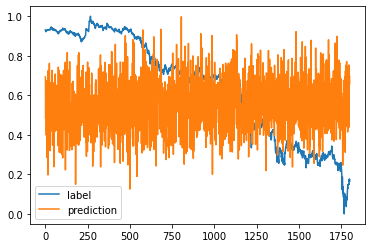

# 3 , loss= 0.09758828580379486 ave_loss= 0.1088


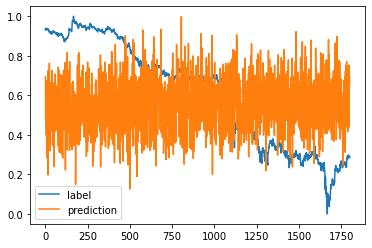

# 4 , loss= 0.09532502293586731 ave_loss= 0.1061


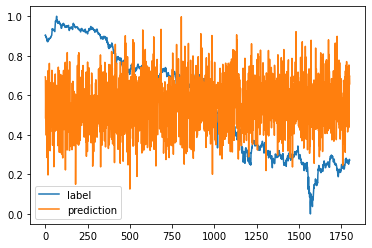

# 5 , loss= 0.0961281806230545 ave_loss= 0.1044


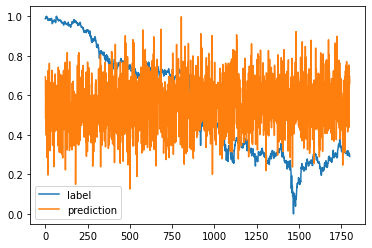

# 6 , loss= 0.09059209376573563 ave_loss= 0.1024


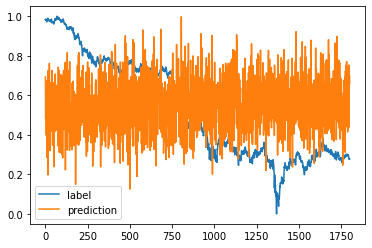

# 7 , loss= 0.08586100488901138 ave_loss= 0.1004


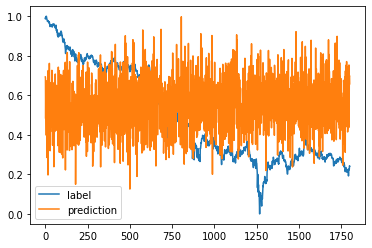

# 8 , loss= 0.0893804281949997 ave_loss= 0.0991


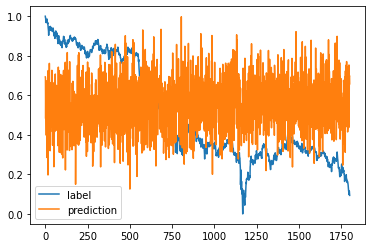

# 9 , loss= 0.09329354763031006 ave_loss= 0.0986


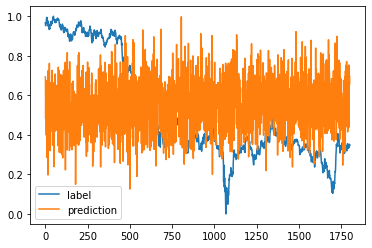

# 10 , loss= 0.08676214516162872 ave_loss= 0.0975


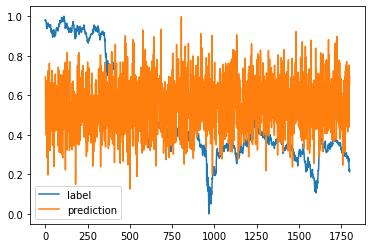

# 11 , loss= 0.08377013355493546 ave_loss= 0.0963


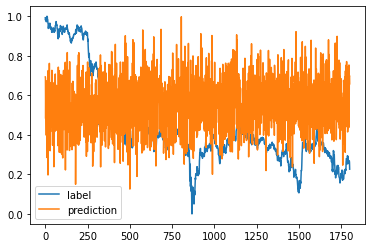

# 12 , loss= 0.08222243934869766 ave_loss= 0.0953


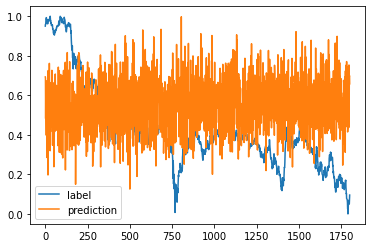

# 13 , loss= 0.08227867633104324 ave_loss= 0.0943


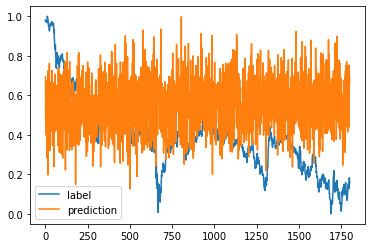

# 14 , loss= 0.06668803095817566 ave_loss= 0.0925


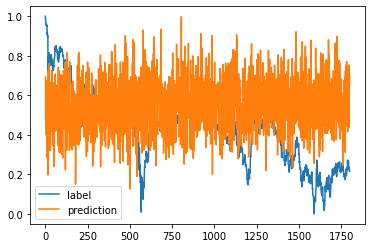

# 15 , loss= 0.061182137578725815 ave_loss= 0.0905


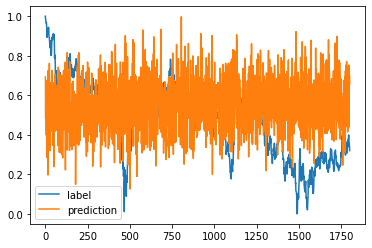

# 16 , loss= 0.06911275535821915 ave_loss= 0.0893


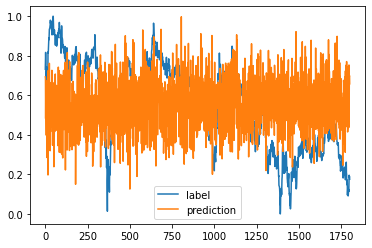

# 17 , loss= 0.0650903657078743 ave_loss= 0.0879


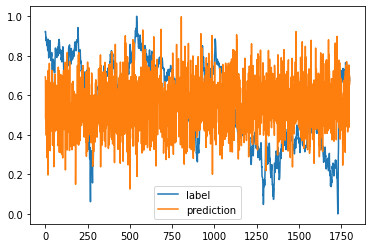

# 18 , loss= 0.06023538485169411 ave_loss= 0.0865


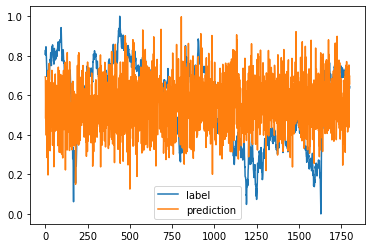

# 19 , loss= 0.05774201452732086 ave_loss= 0.085


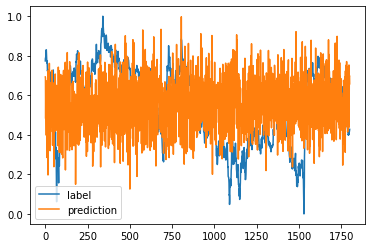

# 20 , loss= 0.05687140300869942 ave_loss= 0.0837


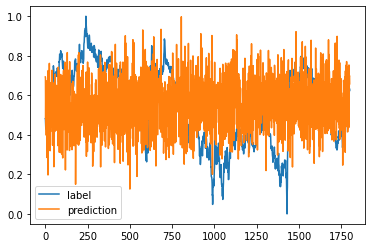

# 21 , loss= 0.05574266240000725 ave_loss= 0.0824


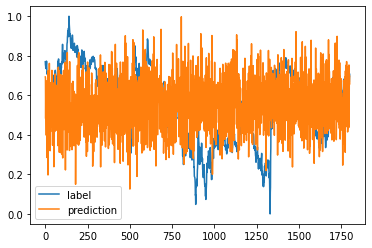

# 22 , loss= 0.05290146544575691 ave_loss= 0.0811


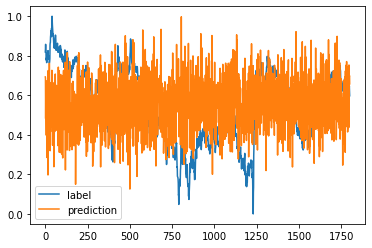

# 23 , loss= 0.058784037828445435 ave_loss= 0.0802


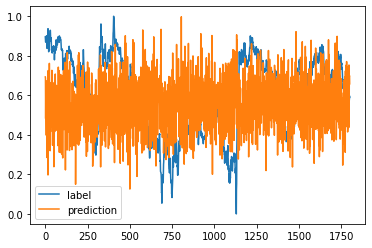

# 24 , loss= 0.052793003618717194 ave_loss= 0.0791


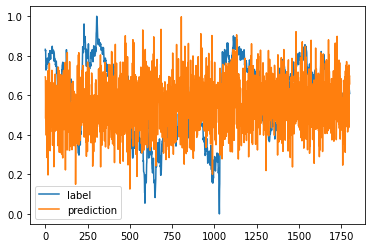

# 25 , loss= 0.05349436402320862 ave_loss= 0.0781


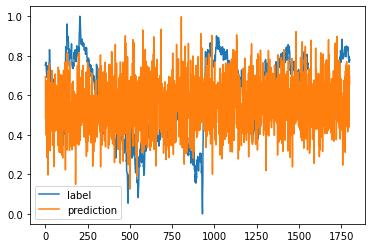

# 26 , loss= 0.0542391799390316 ave_loss= 0.0772


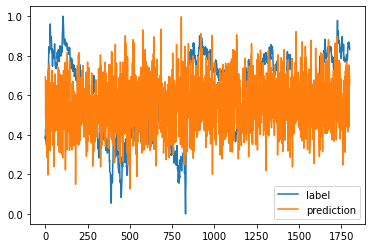

# 27 , loss= 0.05039612948894501 ave_loss= 0.0763


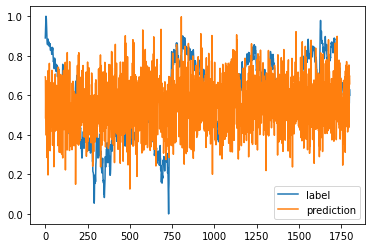

# 28 , loss= 0.050518665462732315 ave_loss= 0.0754


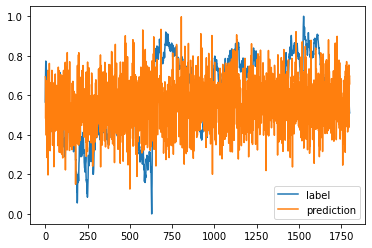

# 29 , loss= 0.048946864902973175 ave_loss= 0.0745


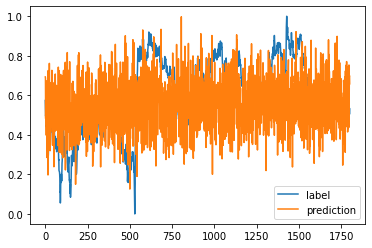

# 30 , loss= 0.04766221344470978 ave_loss= 0.0736


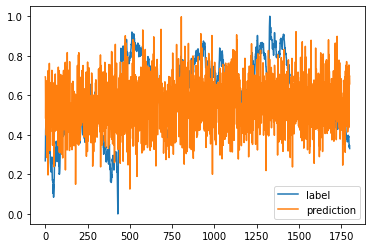

# 31 , loss= 0.04845225811004639 ave_loss= 0.0729


KeyboardInterrupt: ignored

In [20]:
###########################################################
########################### Test ###########################
###########################################################
class Test:
    def doTest(self, model, test_dataloader):
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print('device=', device)
        model.eval()
        count = 0
        sum_mse = 0
        loss_fn = nn.MSELoss()
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            mse = loss_fn(outputs, labels)
            sum_mse += mse.item()
            print('#', count, ', loss=', mse.item(), 'ave_loss=', round(sum_mse / (count+1),4))
            x = np.arange(outputs.detach().cpu().numpy().shape[-1])
            plt.plot(x, labels.detach().cpu().numpy().squeeze(), label='label')
            plt.plot(x, outputs.detach().cpu().numpy().squeeze(), label='prediction')
            plt.legend()
            plt.show()
            count += 1
test = Test()
test.doTest(model, test_dataloader)

In [41]:
train_dataloader.dataset[0][0].shape

torch.Size([2, 180])

In [ ]:
###########################################################
#####################Generate Input Data#######################
###########################################################
class InputDataGenerator:
    def generateInputData(self, from_ind, to_ind, data_len, ma_term):
        start_ind = from_ind
        while True:
            price = MarketData.logclose[start_ind : start_ind + data_len]
            kairi = MarketData.ma_kairi[ma_term][start_ind : start_ind + data_len]
            mmsc = MinMaxScaler(feature_range=(0,1), copy = True)
            

In [ ]:
def call(inputs):
    fl_type = inputs.dtype
    batch_size, max_length, depth = tf.unstack(tf.shape(inputs))

    depth_counter = tf.range(depth) // 2 * 2  # 0, 0, 2, 2, 4, ...
    depth_matrix = tf.tile(tf.expand_dims(depth_counter, 0), [max_length, 1])  # [max_length, depth]
    depth_matrix = tf.pow(10000.0, tf.cast(depth_matrix / depth, fl_type))  # [max_length, depth]

    # cos(x) == sin(x + π/2)
    phase = tf.cast(tf.range(depth) % 2, fl_type) * math.pi / 2  # 0, π/2, 0, π/2, ...
    phase_matrix = tf.tile(tf.expand_dims(phase, 0), [max_length, 1])  # [max_length, depth]

    pos_counter = tf.range(max_length)
    pos_matrix = tf.cast(tf.tile(tf.expand_dims(pos_counter, 1), [1, depth]), fl_type)  # [max_length, depth]

    positional_encoding = tf.sin(pos_matrix / depth_matrix + phase_matrix)
    # [batch_size, max_length, depth]
    positional_encoding = tf.tile(tf.expand_dims(positional_encoding, 0), [batch_size, 1, 1])

    return inputs + positional_encoding

posi = call(tens)
print(posi)

ValueError: ignored

In [ ]:
import tensorflow as tf

# BERT用のトークン分割器を作成する
#tokenizer = tf.keras.models.load_model('bert_model/vocab.txt')
from keras.preprocessing.text import Tokenizer

# BERTへの入力データを作成する
def make_bert_input(text):
    # トークン分割を行う
    tokenizer = Tokenizer()
    tokens = tokenizer.fit_on_sequences(text)
    #tokens = Tokenizer.tokenize(text)
    # BERTが扱う形式に変換する
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    # 各トークンをトークンIDに変換する
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    # BERTが扱う形式に変換する
    segment_ids = [0] * len(token_ids)
    input_mask = [1] * len(token_ids)
    return (token_ids, segment_ids, input_mask)

# 入力文字列を指定してBERTへの入力データを作成する
token_ids, segment_ids, input_mask = make_bert_input("今日は晴れです。")
print(token_ids)
print(segment_ids)
print(input_mask)

TypeError: ignored

In [ ]:
def evensin(pos, dim, n):
    denominator = math.pow(n, (2 * 1) // dim)
    return np.sin(pos / denominator)

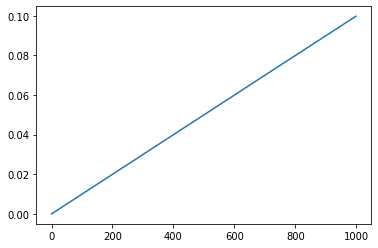

In [ ]:
all_sin = []
for i in range(1000):
    all_sin.append(evensin(i, 1, 100))
plt.plot(all_sin)

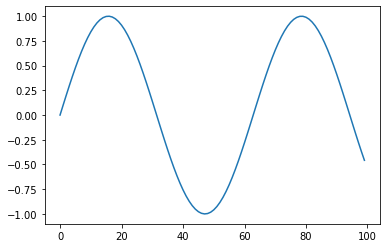

In [ ]:
all_sin = []
for i in range(100):
    all_sin.append(np.sin(i / 10))
plt.plot(all_sin)

In [ ]:
np.sin(1.0)

0.8414709848078965

In [ ]:
np.arange(int(4/2))

array([0, 1])